In [ ]:
# Installing dependencies
!pip install datasets contractions transformers scikit-learn seaborn matplotlib nltk
!pip install torch torchvision torchaudio

In [ ]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import Dataset
from google.colab import drive
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
from torch.nn import CrossEntropyLoss
from transformers import TrainerCallback

In [ ]:
# Mounting drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/mental_health_dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dropping unnamed columns
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

# Taking 6000 samples from the dataset for training
data = data.sample(n=50000,).reset_index(drop=True)

data

,statement,status
0,como que jyp se murio,Normal
1,Spiritual feelings I always seem to get a feel...,Bipolar
2,me too. it always smells so fresh after it rains.,Normal
3,Its not that i worry to much about my life is ...,Depression
4,"Hey guys,I have been very recently diagnosed w...",Depression
...,...,...
49995,He kept holding my arm while talking to me. He...,Stress
49996,It was like an addiction that I cannot end the...,Depression
49997,I have been surviving by a thread this last 1 ...,Suicidal
49998,mules half an hour before graduation ya Allahh...,Normal


In [ ]:
# Download NLTK stopwords (only needed once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    if not isinstance(statement, str):
        return ""
    statement = contractions.fix(statement)
    statement = statement.lower()
    statement = statement.translate(str.maketrans('', '', string.punctuation))
    statement = re.sub(r'\s+', ' ', statement).strip()
    words = statement.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

data['statement'] = data['statement'].apply(clean_statement)

data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,statement,status
0,como que jyp se murio,Normal
1,spiritual feelings always seem get feeling par...,Bipolar
2,always smells fresh rains,Normal
3,worry much life worry always hating cannot kee...,Depression
4,hey guysi recently diagnosed depression anxiet...,Depression
...,...,...
49995,kept holding arm talking kept saying beautiful...,Stress
49996,like addiction cannot end cycle ofive finally ...,Depression
49997,surviving thread last 1 year several attempts ...,Suicidal
49998,mules half hour graduation ya allahhhhhhhhh,Normal


In [ ]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

In [ ]:
# Train test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['statement'], data['label'], test_size=0.2, stratify=data['label'], random_state=42
)

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

In [ ]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})

In [ ]:
# Compute class weights
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
normalized_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

In [ ]:
from transformers import BertForSequenceClassification
import torch.nn as nn
import torch

class BertWithWeightedLoss(BertForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove unsupported keys (e.g., from Trainer)
        kwargs = {k: v for k, v in kwargs.items() if k in ['token_type_ids', 'position_ids', 'head_mask', 'inputs_embeds']}

        # Remove num_items_in_batch from kwargs if present
        kwargs.pop('num_items_in_batch', None)

        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            **kwargs
        )

        # Override loss with weighted loss if class_weights are given
        if labels is not None and self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
            loss = loss_fct(outputs.logits, labels)  # Calculate weighted loss
            outputs.loss = loss  # Update the loss in the outputs
            return outputs  # Return the updated outputs

        return outputs  # Return the original outputs if no weighted loss is applied

In [ ]:
from transformers import BertConfig
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model = BertWithWeightedLoss.from_pretrained('bert-base-uncased', config=config, class_weights=class_weights_tensor)

Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Compute evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# 2. Dynamically determine number of epochs
dataset_size = len(train_dataset)
if dataset_size <= 6000:
    num_epochs = 5
elif dataset_size <= 12000:
    num_epochs = 4
elif dataset_size <= 24000:
    num_epochs = 3
else:
    num_epochs = 2

In [ ]:
# 3. Training Arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_dir="./bert_logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2
)

In [ ]:
# 4. Define Trainer with early stopping and compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

<ipython-input-142-e9b49bda4f3b>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.933800,0.760482,0.757400,0.759483,0.780995,0.757400
2,0.609800,0.690483,0.777800,0.779848,0.789730,0.777800


TrainOutput(global_step=5000, training_loss=0.7273796116828919, metrics={'train_runtime': 2762.8363, 'train_samples_per_second': 28.956, 'train_steps_per_second': 1.81, 'total_flos': 8222589600000000.0, 'train_loss': 0.7273796116828919, 'epoch': 2.0})

In [ ]:
# Predictions
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

In [ ]:
# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

                      precision    recall  f1-score   support

             Anxiety       0.83      0.86      0.84       730
             Bipolar       0.80      0.79      0.79       529
          Depression       0.78      0.64      0.70      2922
              Normal       0.94      0.91      0.93      3106
Personality disorder       0.67      0.72      0.70       202
              Stress       0.51      0.73      0.60       491
            Suicidal       0.64      0.75      0.69      2020

            accuracy                           0.78     10000
           macro avg       0.74      0.77      0.75     10000
        weighted avg       0.79      0.78      0.78     10000



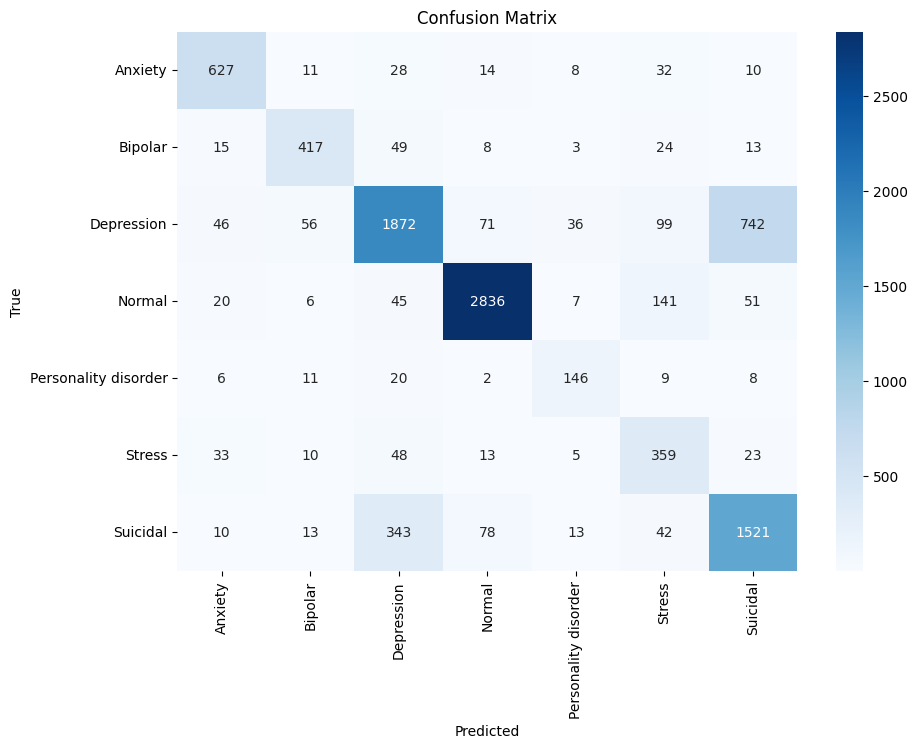

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model, tokenizer, and label encoder
trainer.save_model("./saved_mental_status_bert")
tokenizer.save_pretrained("./saved_mental_status_bert")

('./saved_mental_status_bert/tokenizer_config.json',
 './saved_mental_status_bert/special_tokens_map.json',
 './saved_mental_status_bert/vocab.txt',
 './saved_mental_status_bert/added_tokens.json')

In [ ]:
import pickle
pickle.dump(label_encoder, open('./saved_mental_status_bert_label_encoder.pkl', 'wb'))

# Load back model and tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("./saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("./saved_mental_status_bert")
label_encoder = pickle.load(open('./saved_mental_status_bert_label_encoder.pkl', 'rb'))

In [ ]:
# Detection System
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

In [ ]:
# Test detection
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

In [ ]:
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Depression

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Suicidal

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Depression

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Suicidal

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  0.7778
F1 Score:  0.7798
Precision: 0.7897
Recall:    0.7778


In [ ]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_bert"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"  # Path for the zip file without extension

# ✅ Create a zip archive of the folder
shutil.make_archive(zip_file_path, 'zip', root_dir=zip_file_path)

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# RoBERTa

In [1]:
# Installing dependencies
!pip install datasets contractions transformers scikit-learn seaborn matplotlib nltk
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torc

In [2]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from google.colab import drive
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
from torch.nn import CrossEntropyLoss
from transformers import TrainerCallback
import pickle

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
data = pd.read_csv("/content/drive/MyDrive/mental_health_dataset.csv")
data = data.drop(columns=['Unnamed: 0'], errors='ignore')
data.dropna(inplace=True)

# Sample data (optional)
data = data.sample(n=6000, random_state=42).reset_index(drop=True)

In [5]:
# Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    if not isinstance(statement, str): return ""
    statement = contractions.fix(statement)
    statement = statement.lower()
    statement = statement.translate(str.maketrans('', '', string.punctuation))
    statement = re.sub(r'\s+', ' ', statement).strip()
    tokens = statement.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['statement'] = data['statement'].apply(clean_statement)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
data

,statement,status
0,lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps trying find apps track over...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,favorite thing,Normal
...,...,...
5995,around right photo comfortable place sit beaut...,Depression
5996,tired ready everything life pointless painful ...,Suicidal
5997,friends party man whispers ear likes stare tou...,Stress
5998,add kind info almost thing always felt kind ba...,Depression


In [7]:
# Label encoding
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

In [8]:
# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'],  stratify=data['label'], test_size=0.2, random_state=42)

In [9]:
# Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})

In [11]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [12]:
# Custom Roberta model with weighted loss
from transformers import RobertaForSequenceClassification

class RobertaWithWeightedLoss(RobertaForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        kwargs = {k: v for k, v in kwargs.items() if k in ['token_type_ids', 'position_ids', 'head_mask', 'inputs_embeds']}
        kwargs.pop('num_items_in_batch', None)
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=labels, **kwargs)

        if labels is not None and self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
            loss = loss_fct(outputs.logits, labels)
            outputs.loss = loss

        return outputs

In [13]:
# Load model
from transformers import RobertaConfig
config = RobertaConfig.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model = RobertaWithWeightedLoss.from_pretrained('roberta-base', config=config, class_weights=class_weights_tensor)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaWithWeightedLoss were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [15]:
# Dynamic epoch selection
dataset_size = len(train_dataset)
if dataset_size <= 6000:
    num_epochs = 5
elif dataset_size <= 12000:
    num_epochs = 4
elif dataset_size <= 24000:
    num_epochs = 3
else:
    num_epochs = 2

In [16]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./roberta_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_dir="./roberta_logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2
)

In [17]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

<ipython-input-17-a0a0c21ef9fe>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: minakshi29bharadwaj (minakshi29bharadwaj-myorg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.014600,0.965901,0.676667,0.686222,0.716576,0.676667
2,1.126800,0.943050,0.707500,0.709750,0.718252,0.707500
3,0.572700,0.964740,0.700833,0.690641,0.730211,0.700833
4,0.411900,0.953565,0.729167,0.730851,0.737379,0.729167


TrainOutput(global_step=1200, training_loss=0.8369138715664546, metrics={'train_runtime': 842.2756, 'train_samples_per_second': 28.494, 'train_steps_per_second': 1.781, 'total_flos': 1973421504000000.0, 'train_loss': 0.8369138715664546, 'epoch': 4.0})

                      precision    recall  f1-score   support

             Anxiety       0.61      0.86      0.71        86
             Bipolar       0.58      0.76      0.66        58
          Depression       0.63      0.60      0.61       346
              Normal       0.95      0.86      0.90       379
Personality disorder       0.48      0.62      0.54        26
              Stress       0.54      0.51      0.53        61
            Suicidal       0.63      0.62      0.62       244

            accuracy                           0.71      1200
           macro avg       0.63      0.69      0.65      1200
        weighted avg       0.72      0.71      0.71      1200



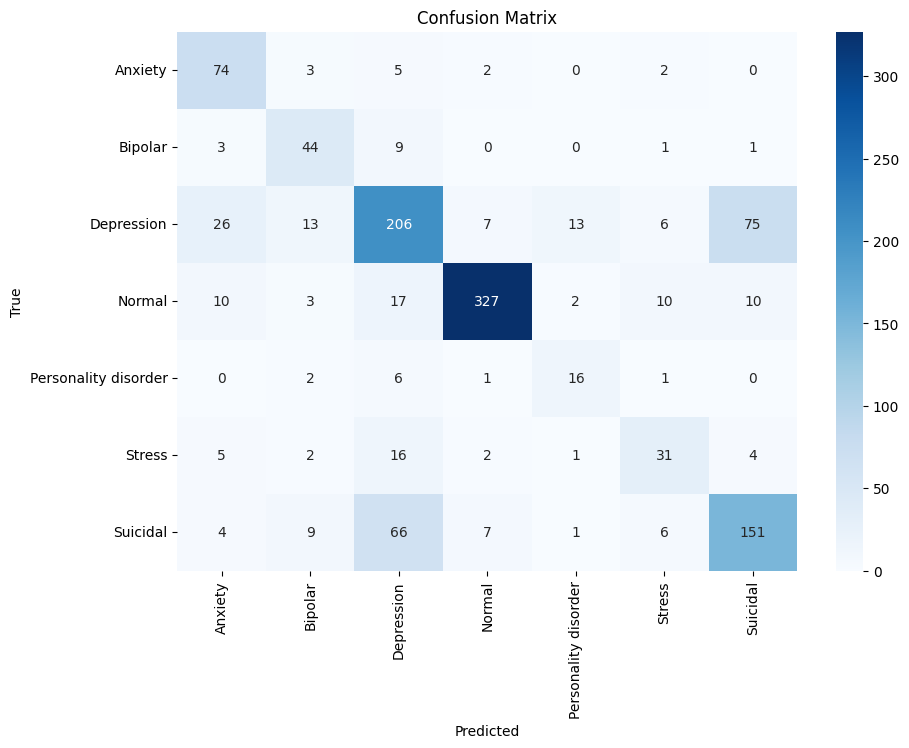

In [19]:
# Evaluate
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print(classification_report(test_labels, pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Save the trained model, tokenizer, and label encoder
trainer.save_model("./saved_mental_status_roberta")
tokenizer.save_pretrained("./saved_mental_status_roberta")

('./saved_mental_status_roberta/tokenizer_config.json',
 './saved_mental_status_roberta/special_tokens_map.json',
 './saved_mental_status_roberta/vocab.json',
 './saved_mental_status_roberta/merges.txt',
 './saved_mental_status_roberta/added_tokens.json')

In [21]:
import pickle
pickle.dump(label_encoder, open('./saved_mental_status_roberta_label_encoder.pkl', 'wb'))

In [22]:
# Load back model and tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("./saved_mental_status_roberta")
tokenizer = AutoTokenizer.from_pretrained("./saved_mental_status_roberta")
label_encoder = pickle.load(open('./saved_mental_status_roberta_label_encoder.pkl', 'rb'))

In [23]:
# Detection system
def detect_mental_status(text):
    cleaned = clean_statement(text)
    inputs = tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([pred_class])[0]

# Test examples
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

for text in sample_texts:
    print(f"Text: {text}\nPredicted: {detect_mental_status(text)}\n")

Text: I feel perfectly fine today, nothing to worry about.
Predicted: Anxiety

Text: I can't stop thinking about what will happen if things go wrong.
Predicted: Suicidal

Text: Lately, I've been on a high, feeling like I can do anything!
Predicted: Depression

Text: I'm so sad, I just can't seem to get out of bed anymore.
Predicted: Suicidal

Text: I'm constantly thinking about how much better everyone else is doing than me.
Predicted: Normal

Text: I don't think I can keep going, everything feels so hopeless.
Predicted: Depression

Text: I had a really good day, spent some time with my friends.
Predicted: Normal

Text: I'm overwhelmed by the idea that I might lose everything.
Predicted: Depression

Text: I feel like nothing matters anymore, I just want to give up.
Predicted: Suicidal

Text: I'm okay today, but sometimes I get really anxious for no reason.
Predicted: Anxiety



In [24]:
# ... (RoBERTa code before this point remains unchanged) ...

# Evaluate
predictions = trainer.predict(test_dataset)
# ✅ Assign predicted labels based on the current predictions
predicted_labels = np.argmax(predictions.predictions, axis=1)

print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# ... (Rest of RoBERTa code) ...

# Calculate metrics based on the current predicted labels for RoBERTa
accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

                      precision    recall  f1-score   support

             Anxiety       0.61      0.86      0.71        86
             Bipolar       0.58      0.76      0.66        58
          Depression       0.63      0.60      0.61       346
              Normal       0.95      0.86      0.90       379
Personality disorder       0.48      0.62      0.54        26
              Stress       0.54      0.51      0.53        61
            Suicidal       0.63      0.62      0.62       244

            accuracy                           0.71      1200
           macro avg       0.63      0.69      0.65      1200
        weighted avg       0.72      0.71      0.71      1200

Accuracy:  0.7075
F1 Score:  0.7097
Precision: 0.7183
Recall:    0.7075


In [25]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_roberta"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_roberta"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_roberta"  # Path for the zip file without extension

# ✅ Create a zip archive of the folder
shutil.make_archive(zip_file_path, 'zip', root_dir=zip_file_path)

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  0.7075
F1 Score:  0.7097
Precision: 0.7183
Recall:    0.7075
